In [1]:
#Import libraries
import pandas as pd
import numpy as np
from rdkit import Chem
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Normalization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset using pandas functionality
ddr1_data = pd.read_parquet('../data/ddr1_selected_data_model_2.parquet')


# Define variables for training to predict target enrichment for linear regression
y = ddr1_data['target_enrichment']

# Variables to drop
drop = ['target_enrichment']
X = ddr1_data.drop(drop, axis=1)
print(X.columns)
# Name the features
X_features = ['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed']

# Convert dataframes to numpy arrays for better computation
X = X.values
y = y.values

# Scale features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)



# Set the seed for reproducibility
tf.random.set_seed(1234)

# Define the regression model
model = Sequential(
    [
        tf.keras.Input(shape=(5,)),  # Input shape matches the number of features
        Dense(50, activation="relu", name="layer1"),
        Dense(30, activation="relu", name="layer2"),
        Dense(1, activation="linear", name="output_layer"),  # Linear activation for regression
    ]
)

# Compile the model with a regression loss and optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Optimizer
    loss="mean_squared_error",  # Loss function for regression
    metrics=["mean_absolute_error"],  # Additional metrics
)

# Model summary to verify structure
model.summary()


#Fit model to X
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    verbose=1,
)

Index(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed'],
      dtype='object')
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 50)                300       
                                                                 
 layer2 (Dense)              (None, 30)                1530      
                                                                 
 output_layer (Dense)        (None, 1)                 31        
                                                                 
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2024-11-27 19:37:57.279164: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


21875/21875 [==============================] - 6s 268us/step - loss: 0.7775 - mean_absolute_error: 0.4045
Epoch 2/50
21875/21875 [==============================] - 6s 267us/step - loss: 0.7712 - mean_absolute_error: 0.4023
Epoch 3/50
21875/21875 [==============================] - 6s 264us/step - loss: 0.7685 - mean_absolute_error: 0.4015
Epoch 4/50
21875/21875 [==============================] - 6s 266us/step - loss: 0.7666 - mean_absolute_error: 0.4011
Epoch 5/50
21875/21875 [==============================] - 6s 266us/step - loss: 0.7652 - mean_absolute_error: 0.4006
Epoch 6/50
21875/21875 [==============================] - 6s 270us/step - loss: 0.7643 - mean_absolute_error: 0.4002
Epoch 7/50
21875/21875 [==============================] - 6s 273us/step - loss: 0.7635 - mean_absolute_error: 0.3999
Epoch 8/50
21875/21875 [==============================] - 6s 265us/step - loss: 0.7635 - mean_absolute_error: 0.4000
Epoch 9/50
21875/21875 [==============================] - 6s 266us/step - l

In [2]:
ddr1_data

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,target_enrichment
0,13.150889,13.150889,0.088747,-1.018914,0.169284,0.352696
1,13.634733,13.634733,0.090835,-1.080458,0.291476,1.482711
2,13.598434,13.598434,0.071635,-0.164736,0.475002,0.440103
3,13.193850,13.193850,0.170769,-0.610430,0.529854,0.337236
4,12.498264,12.498264,0.112168,-0.991033,0.432167,0.321008
...,...,...,...,...,...,...
999995,13.303591,13.303591,0.132303,-4.618751,0.368279,0.295446
999996,13.617307,13.617307,0.046965,-4.795884,0.326509,0.440103
999997,14.318077,14.318077,0.054159,-0.870076,0.373128,0.295446
999998,13.397223,13.397223,0.101726,-0.636557,0.606758,0.295446


9375/9375 [==============================] - 2s 222us/step - loss: 0.7669 - mean_absolute_error: 0.3902


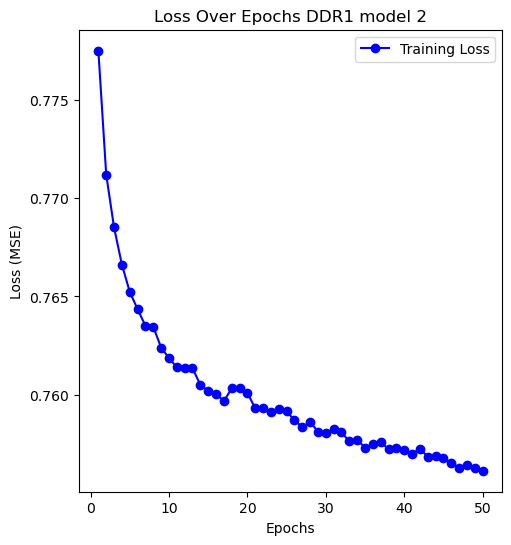

In [3]:
# Evaluate the model
model.evaluate(X_test, y_test)


def plot_metrics(history, save_path):
    # Extract the metrics
    training_loss = history.history['loss']
    validation_loss = history.history.get('val_loss', None)
    training_mae = history.history['mean_absolute_error']
    validation_mae = history.history.get('val_mean_absolute_error', None)

    epochs = range(1, len(training_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, 'b-o', label="Training Loss")
    if validation_loss is not None:
        plt.plot(epochs, validation_loss, 'r-o', label="Validation Loss")
    plt.title("Loss Over Epochs DDR1 model 2")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()

    #Save figure
    plt.savefig(save_path)

# Call the function with the history object
plot_metrics(history, "../results/model2_ddr1.png")


In [4]:
#Save model
model.save('../models/ddr1_model_2.h5')